- Long, short portfolio 
数据需要从同一天开始

In [492]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import seed
from numpy import random



In [732]:
#load the data
JNJ=pd.read_csv("JNJ-bloomberg.csv")
PFE=pd.read_csv("PFE-bloomberg.csv")
AMZN=pd.read_csv("daily_adjusted_AMZN.csv")
DIS=pd.read_csv("daily_adjusted_DIS.csv")
APPL=pd.read_csv("daily_adjusted_AAPL.csv")
# transform dates to datetime 
JNJ.Dates=pd.to_datetime(JNJ.Dates)
PFE.Dates=pd.to_datetime(PFE.Dates)
AMZN.timestamp=pd.to_datetime(AMZN.timestamp)
DIS.timestamp=pd.to_datetime(DIS.timestamp)
APPL.timestamp=pd.to_datetime(APPL.timestamp)

# set datetime as the index of the data frame
JNJ=JNJ.set_index(['Dates'])
PFE=PFE.set_index(['Dates'])
AMZN=AMZN.set_index(['timestamp'])
DIS=DIS.set_index(['timestamp'])

APPL=APPL.set_index(['timestamp'])


JNJ['log return']=np.log(JNJ['PX_LAST']/JNJ['PX_LAST'].shift(-1))
PFE['log return']=np.log(PFE['PX_LAST']/PFE['PX_LAST'].shift(-1))

stock1=JNJ.rename(columns={'PX_LAST':'price'})
stock2=PFE.rename(columns={'PX_LAST':'price'})
DIS=DIS.rename(columns={'adjusted_close':'price'})
APPL=APPL.rename(columns={'adjusted_close':'price'})
AMZN=AMZN.rename(columns={'adjusted_close':'price'})

In [733]:
AMZN

,open,high,low,close,price,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2021-12-09,3515.00,3539.390,3482.79,3483.42,3483.42,2303091,0,1
2021-12-08,3523.01,3543.600,3495.01,3523.16,3523.16,2262683,0,1
2021-12-07,3492.00,3549.990,3466.69,3523.29,3523.29,3320536,0,1
2021-12-06,3393.00,3473.910,3338.69,3427.37,3427.37,3443000,0,1
2021-12-03,3455.00,3469.865,3338.60,3389.79,3389.79,4035550,0,1
...,...,...,...,...,...,...,...,...
1999-11-05,64.75,65.500,62.25,64.94,64.94,11091400,0,1
1999-11-04,67.19,67.190,61.00,63.06,63.06,16759200,0,1
1999-11-03,68.19,68.500,65.00,65.81,65.81,10772100,0,1


In [616]:
# single stock 
class Stock:
    def __init__(self,n,data,l):
        self.name=n
        self.date=data.iloc[:252*l].index
        self.price=data.loc[:,'price']
        self.logreturn=np.log(data['price']/data['price'].shift(-1))
        
    def mean(self,lamb=0.9989,weighted=False,windowlen=5):
        '''
        calculate weighted average mean
        windowlen: default=5
        lamb: default=0.9989
        '''
        if weighted: 
            mean_total=[]
            length=int(min(np.ceil(np.log(0.01)/np.log(lamb)),5000))
            for i in range(len(self.date)):
                close=self.logreturn.iloc[i:i+length]
                x=np.arange(len(close))
                exp=lamb**x
                mean_total.append((1-lamb)*np.sum(exp*close))
            return pd.Series(mean_total,index=self.date)
        else:
            return self.logreturn[::-1].rolling(252*windowlen).mean()[::-1].loc[self.date]

    def std(self,lamb=0.9989,weighted=False,windowlen=5):
        '''
        weigthed average standard deviation
        input: 
        '''
        if weighted:
            sdv=[]
            length=int(min(np.ceil(np.log(0.01)/np.log(lamb)),5000))
            mean=self.mean(lamb,weighted,windowlen)
            for j in range(len(self.date)):
                rn=0
                close=self.logreturn.iloc[j:j+length]
                x=np.arange(len(close))
                exp=lamb**x
                rn=(1-lamb)*np.sum(exp*(close**2))
                sdv.append((rn-mean[j]**2)**(1/2))
            return pd.Series(sdv,index=self.date)
        else:
            return self.logreturn[::-1].rolling(252*windowlen).std()[::-1].loc[self.date]
    def Drift(self,t=1/252,windowlen=5,weighted=False,lamb=0.9989):
        '''
        estimated drift
        '''
        return (self.mean(lamb,weighted,windowlen)*(1/t)+self.Vol(t,windowlen,weighted,lamb)**2/2)
    def Vol(self,t=1/252,windowlen=5,weighted=False,lamb=0.9989):
        '''
        enter the weighted or unweigthed standard deviation
        '''
        return self.std(lamb,weighted,windowlen)*((1/t)**(1/2))
    def parametric_VaR(self,V0=10000,T=5/252,windowlen=5,weighted=False,lamb=0.9989,t=1/252,long=True,p=0.99):
        '''
        Normalized parametric VaR assuming the stocks follow GBM
        '''
        vol=self.Vol(t,windowlen,weighted,lamb)
        drift=self.Drift(t,windowlen,weighted,lamb)
        if long:
            exp=np.exp(vol*(T**(1/2))*(norm.ppf(1-p))+(drift-np.power(vol,2)/2)*T)
            return V0-V0*exp
        else:
            exp=np.exp(vol*(T**(1/2))*(norm.ppf(p))+(drift-np.power(vol,2)/2)*T)
            return V0*exp-V0 
    def historical_VaR(self,V0=10000,p=0.99,windowlen=5,relative=True,long=True,day=5):
        '''
        
        '''
        log_return=np.log(self.price/self.price.shift(-day))
        hist_VaR=[]
        if long:
            if relative:
                for i in range(len(self.date)):
                    hist_return=log_return[i:i+252*windowlen].sort_values()
                    hist_VaR.append(V0-V0*np.exp(hist_return[int(np.floor(252*windowlen*(1-p)))]))
            else:
                for i in range(len(self.date)):
                    hist_return=(self.price-self.price.shift(-day))[i:i+252*windowlen].sort_values()
                    hist_VaR.append(-V0/self.price[i]*hist_return[int(np.floor(252*windowlen*(1-p)))])
        else:
            if relative:
                for i in range(len(self.date)):
                    hist_return=(-log_return[i:i+252*windowlen]).sort_values()
                    hist_VaR.append(V0*np.exp(-hist_return[int(np.floor(252*windowlen*(1-p)))])-V0)
            else:
                for i in range(len(self.date)):
                    hist_return=(self.price.shift(-day)-self.price)[i:i+252*windowlen].sort_values()
                    hist_VaR.append(-V0/self.price[i]*hist_return[int(np.floor(252*windowlen*(1-p)))])
        return pd.Series(hist_VaR,index=self.date)
    def MC_VaR(portfolio,windowlen,T,t,weighted=False,lamb=0.9989,sample=10000):
        losses=[]
        n=len(portfolio)
        length=int(min(np.ceil(np.log(0.01)/np.log(lamb)),5000))
        sig,mu,price=pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
        for i in portfolio:
            price[i.name]=i.price
            sig[i.name]=i.Vol(t,windowlen,weighted,lamb)
            mu[i.name]=i.Drift(t,windowlen,weighted,lamb)
        for dat in range(len(portfolio[i].date)):
            corM=np.zeros([n,n])
            for i in range(n):
                corM[i,i]=T
                if i <(l-1):
                    for j in range(i+1,n):
                        returns=pd.concat(
                            [portfolio[i].logreturn[dat,dat+252*windowlen],portfolio[j].logreturn[dat,dat+252*windowlen]],axis=1,keys=[stock1.name,stock2.name])[::-1]
                        if weighted:
                            corM[i,j]=returns.cov().iloc[1,0]/(sig1[i]*sig2[i])*T
            W=np.random.multivariate_normal(np.zeros(n), corM,sample).T
            val=np.sum(shares*price.iloc[dat,:]*np.exp((mu.iloc[dat,:]-sig.iloc[dat,:]**2/2)*T)+sig.iloc[dat,:]*W)
            loss=val-np.sum(shares*price.iloc[dat,:])
            loss.append(V0/shares*price.iloc[dat,:]*-sorted(loss)[int(sample*(1-p))])
        return loss

In [734]:
amzn=Stock('AMZN',AMZN,1)
dis=Stock('DIS',DIS,1)
appl=Stock('Apple',APPL,1)

timestamp
2021-12-09   -0.002974
2021-12-08    0.022527
2021-12-07    0.034833
2021-12-06    0.021275
2021-12-03   -0.011794
                ...   
1999-11-05    0.054571
1999-11-04    0.025680
1999-11-03    0.015456
1999-11-02    0.033322
1999-11-01         NaN
Name: price, Length: 5564, dtype: float64

In [712]:
def MC_VaR(portfolio,shares,V0=10000,windowlen=5,T=5/252,t=1/252,weighted=False,lamb=0.9989,sample=1000,p=0.99):
        losses=[]
        n=len(portfolio)
        sig,mu,price,Mean=pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
        length=int(min(np.ceil(np.log(0.01)/np.log(lamb)),5000))
        x=np.arange(length)
        exp=lamb**x
        for i in portfolio:
            price[i.name]=i.price
            sig[i.name]=i.Vol(t,windowlen,weighted,lamb)
            mu[i.name]=i.Drift(t,windowlen,weighted,lamb)
            Mean[i.name]=i.mean(lamb,weighted,windowlen)
        for dat in range(len(portfolio[0].date)):
            corM=np.zeros([n,n])
            for i in range(n):
                corM[i,i]=T
                if i <(n-1):
                    for j in range(i+1,n):
                        if weighted:
                            returns=pd.concat([portfolio[i].logreturn[dat:dat+length],portfolio[j].logreturn[dat:dat+length]],axis=1,keys=[portfolio[i].name,portfolio[j].name])[::-1]
                            cov=np.sum(returns.product(axis=1)*exp)/np.sum(exp)-Mean.iloc[dat,i]*Mean.iloc[dat,j]
                            corM[i,j]=1/t*cov/(sig.iloc[dat,i]*sig.iloc[dat,j])*T
                            corM[j,i]=1/t*cov/(sig.iloc[dat,i]*sig.iloc[dat,j])*T
                        else:
                            returns=pd.concat([portfolio[i].logreturn[dat:dat+252*windowlen],portfolio[j].logreturn[dat:dat+252*windowlen]],axis=1,keys=[portfolio[i].name,portfolio[j].name])[::-1]
                            corM[i,j]=1/t*returns.cov().iloc[1,0]/(sig.iloc[dat,i]*sig.iloc[dat,j])*T
                            corM[j,i]=1/t*returns.cov().iloc[1,0]/(sig.iloc[dat,i]*sig.iloc[dat,j])*T
            W=np.random.multivariate_normal(np.zeros(n), corM,sample).T
            val=0
            for i in range(n):
                val+=shares[i]*price.iloc[dat,i]*np.exp((mu.iloc[dat,i]-sig.iloc[dat,i]**2/2)*T+sig.iloc[dat,i]*W[i])
            loss=val-np.sum(shares*price.iloc[dat,:])
            losses.append(V0/np.sum(shares*price.iloc[dat,:])*-sorted(loss)[int(sample*(1-p))])
        return pd.Series(losses,index=portfolio[0].date)

In [ ]:
MC_VaR([appl,dis,amzn],[99,138,3],windowlen=1,weighted=True)

In [476]:
def corr(stock1,stock2,t=1/252,windowlen=5,weighted=False,lamb=0.9989):
    '''
    calculate pairwise correlation given two stock
    '''
    sig1=stock1.Vol(t,windowlen,weighted,lamb)
    sig2=stock2.Vol(t,windowlen,weighted,lamb)
    datelen=len(stock1.date) #len of date
    corr=[]
    cov=[]
    returns=pd.concat(
    [stock1.logreturn,stock2.logreturn],axis=1,keys=[stock1.name,stock2.name])[::-1]
    returns.sort_index(ascending=False)
    length=int(min(np.ceil(np.log(0.01)/np.log(lamb)),5000))
    if weighted:
        mean1,mean2=stock1.mean(lamb,weighted,windowlen),stock2.mean(lamb,weighted,windowlen)
        x=np.arange(length)
        exp=lamb**x
        print(length)
        for i in range(datelen):
            cov.append(np.sum(returns.iloc[i:i+length].product(axis=1)*exp)/np.sum(exp)-mean1[i]*mean2[i])
            corr.append(1/t*cov[i]/(sig1[i]*sig2[i]))
        return pd.Series(corr,index=stock1.date)
    else:
        for i in range(datelen):
            corr.append(1/t*returns.iloc[i:i+252*windowlen].cov().iloc[1,0]/(sig1[i]*sig2[i]))
        return pd.Series(corr,index=stock1.date)


In [433]:
def normal_VaR(portfolio,shares,V0=10000,T=5/252,windowlen=5,weighted=False,
               lamb=0.9989,t=1/252,po='long',p=0.99):
    '''
    calculate portfolio VaR assuming nomral, can take any number of stock
    need to have enough length of log return so that the window size fit (enough) data range 
    '''
    l,datlen=len(portfolio), len(portfolio[0].date)
    VaR,Corr=[],[]
    mu,sig,price=[],[],pd.DataFrame()
    for i in portfolio:
        mu.append(i.Drift(t,windowlen,weighted,lamb))
        sig.append(i.Vol(t,windowlen,weighted,lamb))
        price[i.name]=i.price
    for i in range(l):
        if i<(l-1):
            for j in range(i+1,l):
                Corr.append(corr(portfolio[i],portfolio[j],t,windowlen,weighted,lamb))
    for dat in range(datlen):
        EV=0
        EV2=0
        count=0            
        for i in range(l):
            mu1=mu[i]
            sig1=sig[i]
            price1=price.iloc[:,i]
            val1=price1[dat]*shares[i]
            EV+=val1*np.exp(mu1[dat]*T)
            EV2+=val1**2*np.exp((2*mu1[dat]+sig1[dat]**2)*T)
            if i < (l-1):
                for j in range(i+1,l):
                    mu2=mu[j]
                    sig2=sig[j]
                    price2=price.iloc[:,j]
                    val2=price2[dat]*shares[j]
                    EV2+=2*val1*val2*np.exp((mu1[dat]+mu2[dat]+Corr[count][dat]*sig2[dat]*sig1[dat])*T)
                    count+=1
        std=(EV2-EV**2)**(1/2)
        VaR.append(
            (np.sum(shares*price.iloc[dat,:])-(EV+norm.ppf(1-p)*std))*V0/(np.sum(shares*price.iloc[dat,:])))
    return pd.Series(VaR,index=portfolio[0].date)

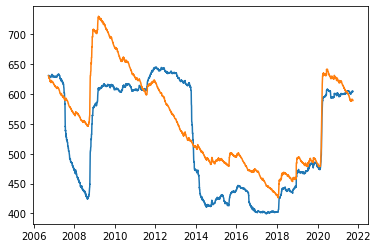

In [371]:
portfolio=[Stock1,Stock2]
shares=[99,138]
#normal_VaR(portfolio,shares)
plt.plot(normal_VaR(portfolio,shares))
plt.plot(normal_VaR(portfolio,shares,weighted=True))